In [19]:
import rasterio 
from pathlib import Path
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
os.chdir("/scratch/ewalt/pdm/rs-uncertainty/")

In [13]:
S2REPRDIR = "gee_data/reprojected_dirs"

In [10]:
islice, jslice = slice(470, 600), slice(150, 300)

In [4]:
result_dirs = [p.path for p in 
               os.scandir("/scratch/ewalt/pdm/rs-uncertainty/results/cloud_exp/2023-06-19_19-46-00")]

In [5]:
result_dirs[0]

'/scratch/ewalt/pdm/rs-uncertainty/results/cloud_exp/2023-06-19_19-46-00/1023_20180824T105019'

1023_20180824T105019


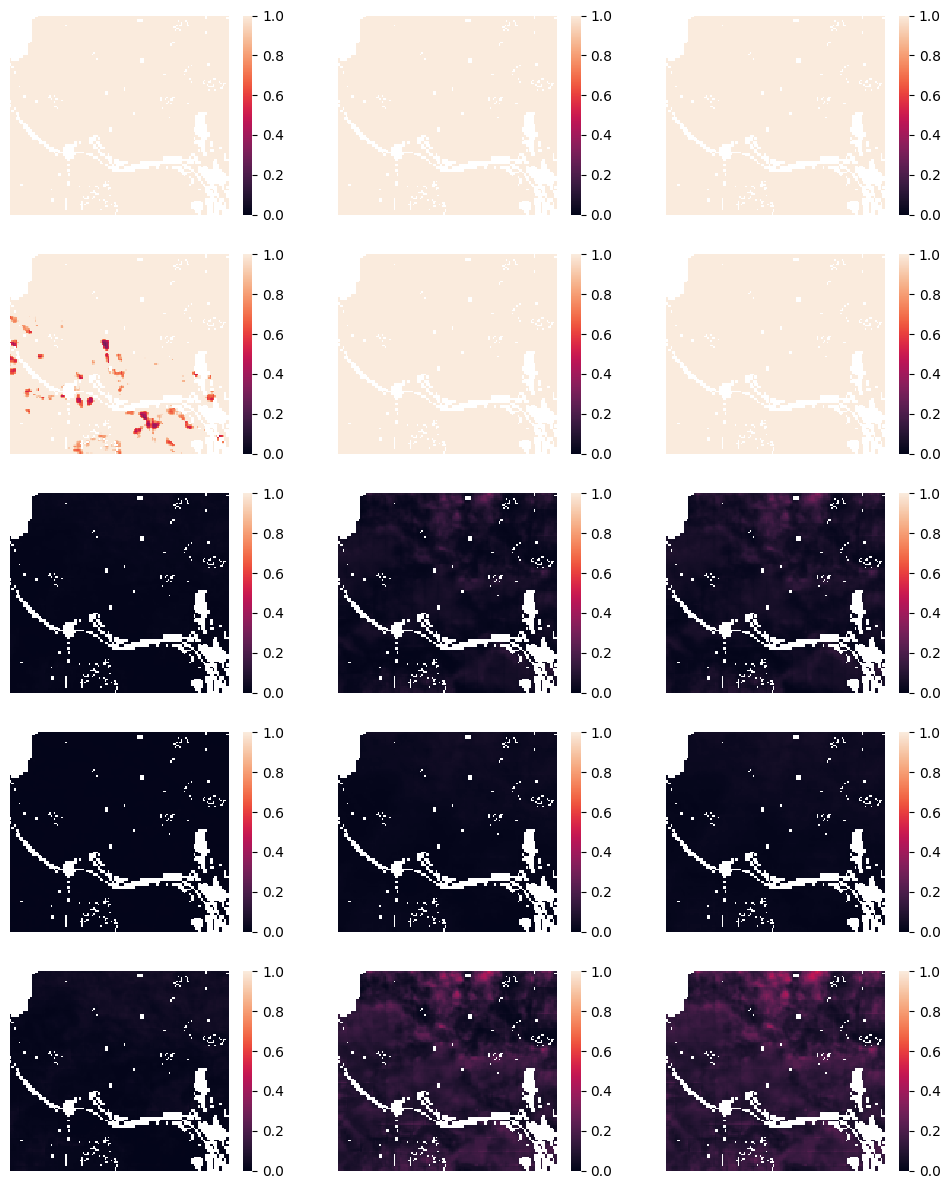

1023_20180523T104019


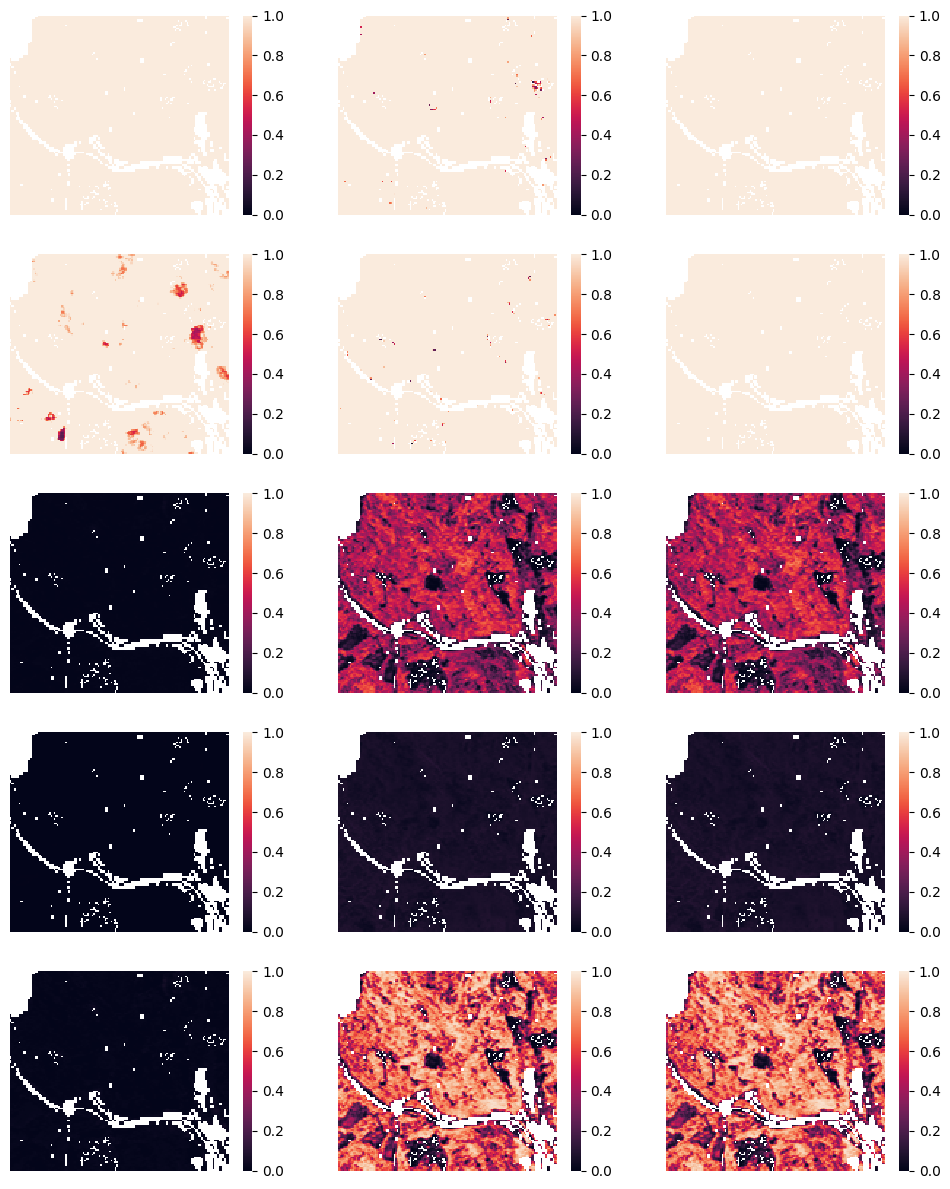

1023_20180610T105031


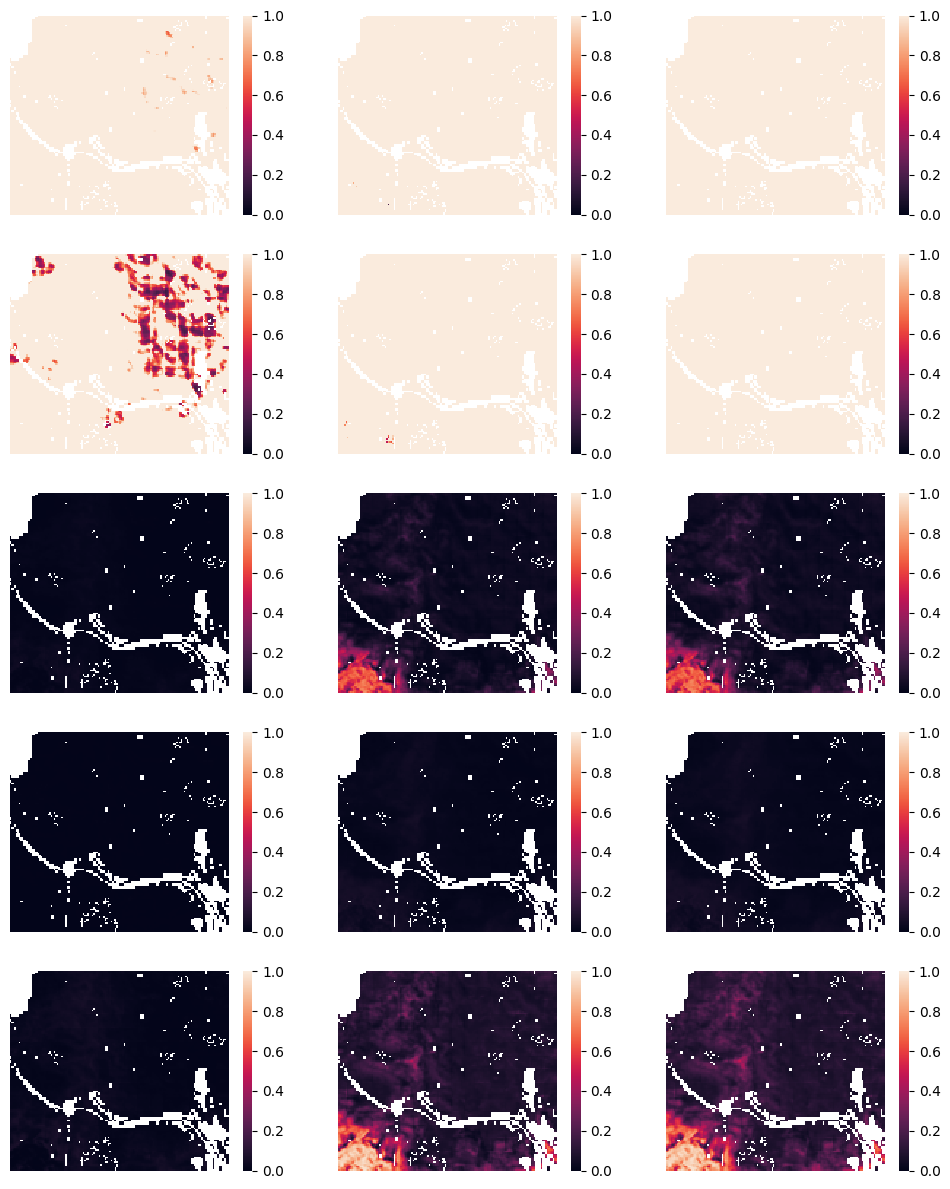

1023_20180503T104019


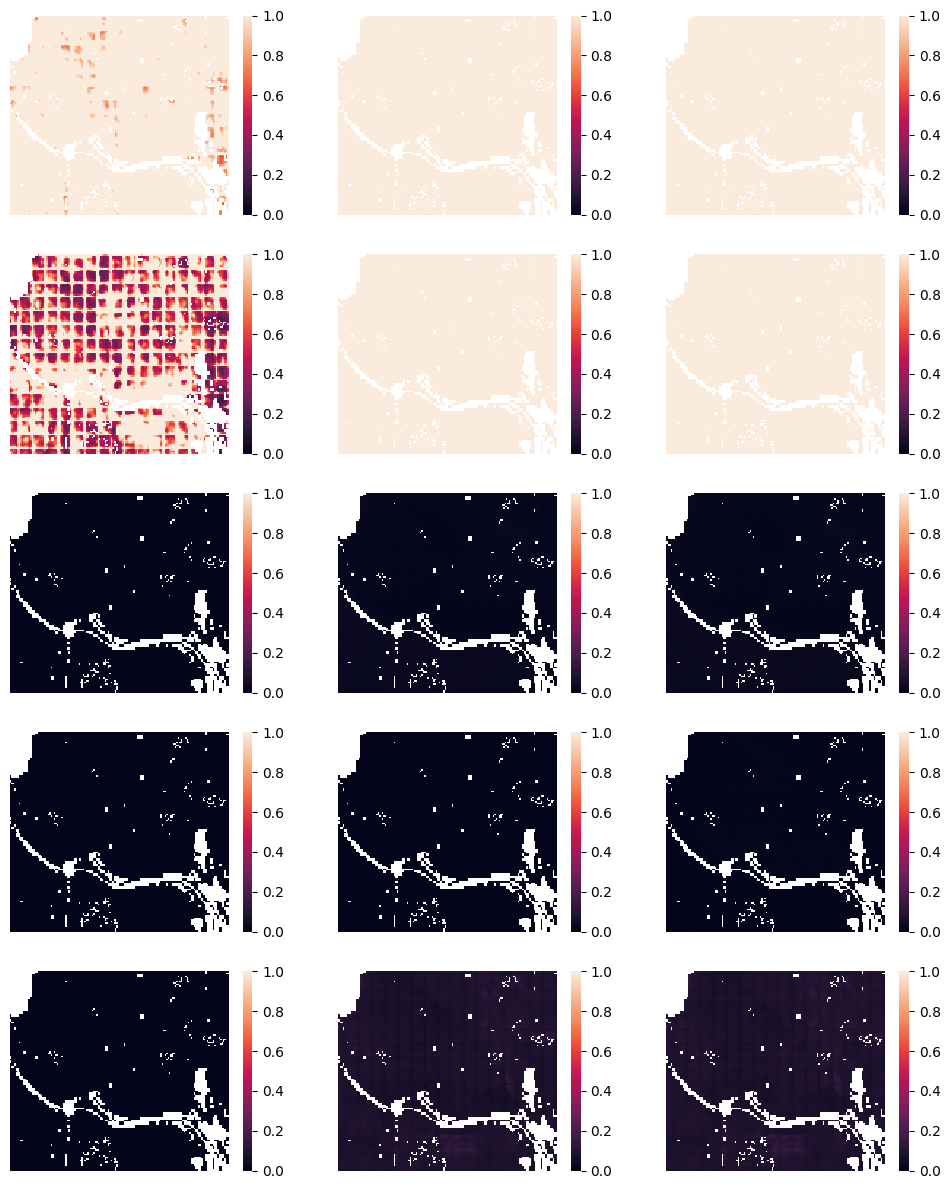

1023_20180908T105021


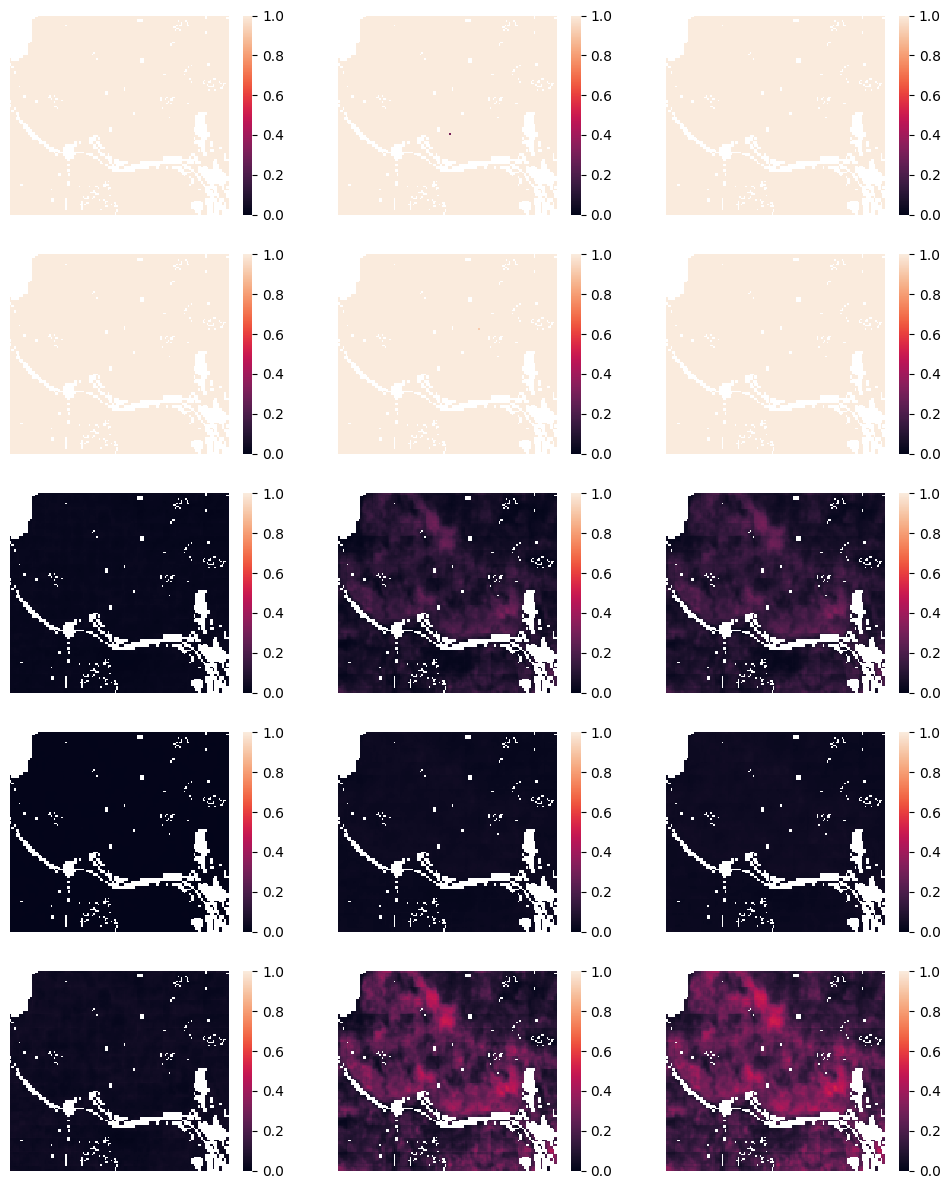

1023_20180531T105031


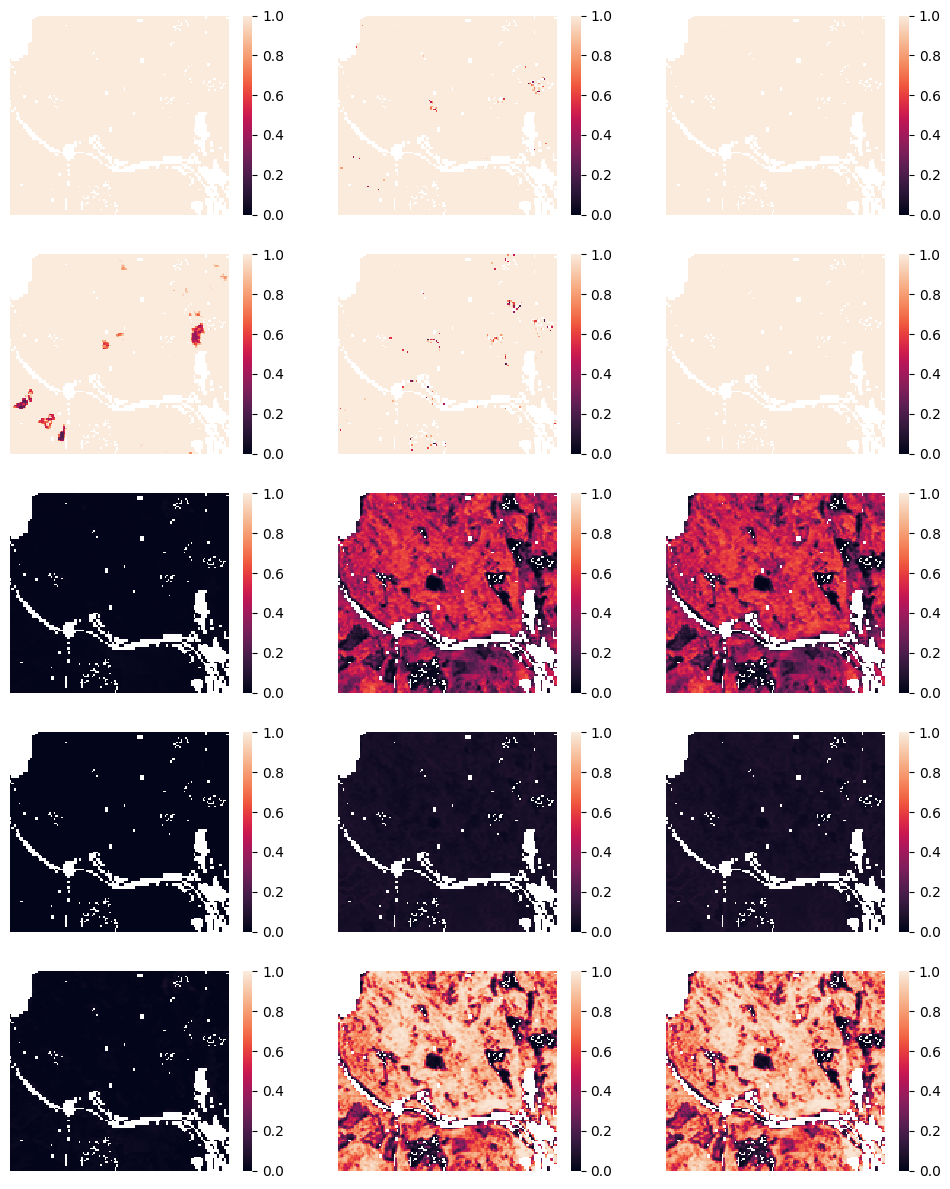

1023_20180620T105031


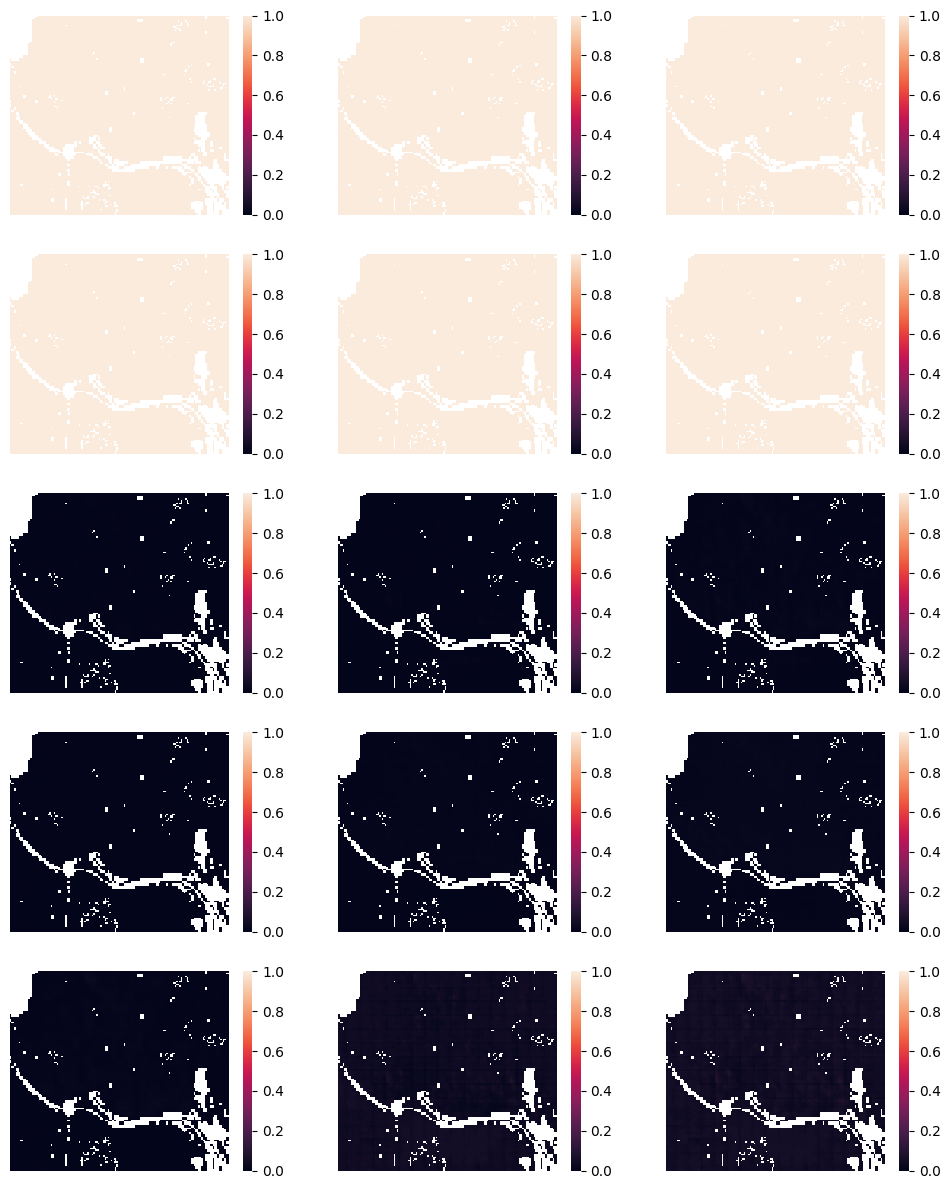

1023_20180806T104021


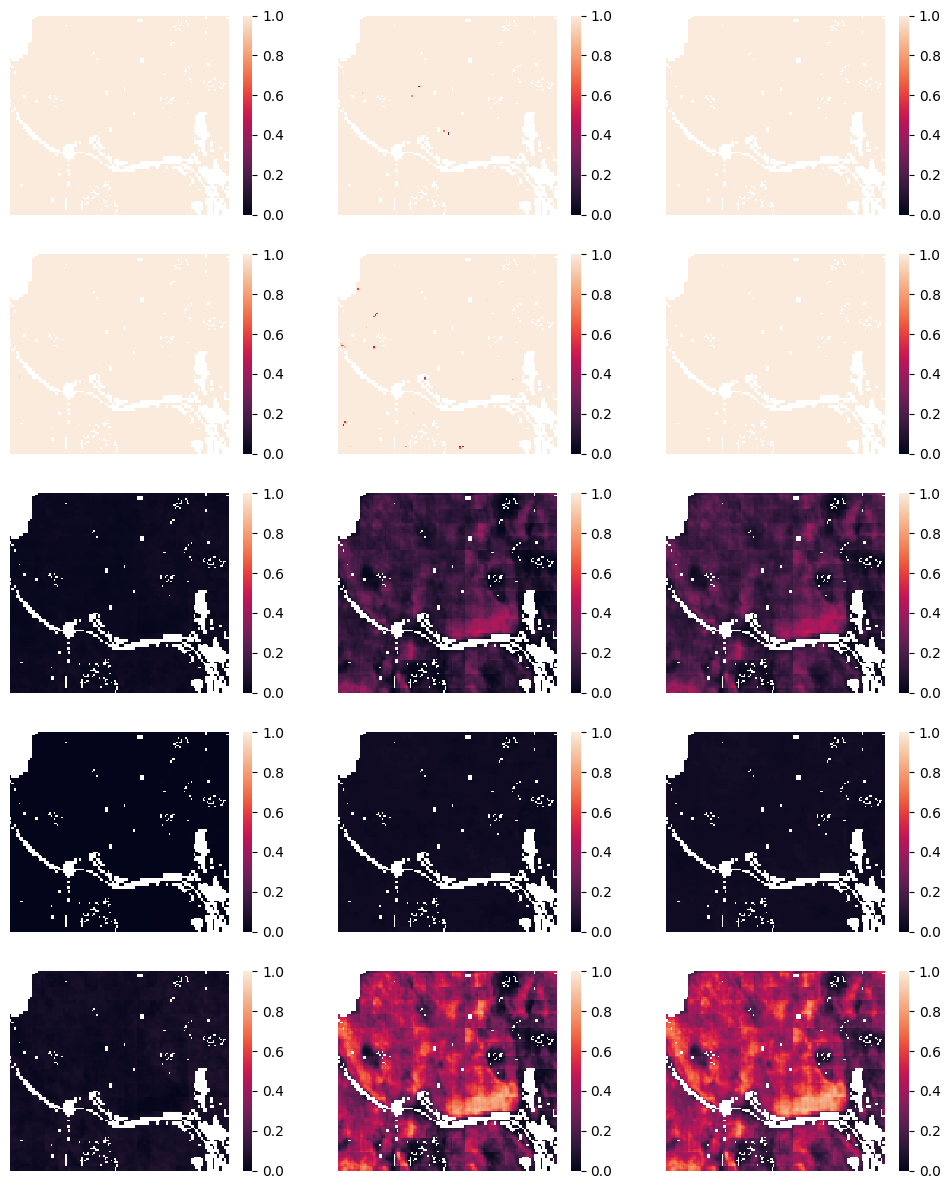

In [12]:
valid_dirs = []
for i, d in enumerate(result_dirs):
    alp = os.path.join(d, "1023_aleatoric.tif")
    epp = os.path.join(d, "1023_epistemic.tif")
    prd = os.path.join(d, "1023_variance.tif")
    if not all([os.path.exists(p) for p in [alp, epp, prd]]): continue
    valid_dirs.append(d)
    print(d.split("/")[-1])
    with rasterio.open(alp) as f: aleatoric = f.read(f.indexes)[:,islice,jslice]
    with rasterio.open(epp) as f: epistemic = f.read(f.indexes)[:,islice,jslice]  
    with rasterio.open(prd) as f: predictive = f.read(f.indexes)[:,islice,jslice]
    fig, axs = plt.subplots(ncols=3, nrows=5, figsize=(12, 15))
    for j in range(5):
        sns.heatmap(aleatoric[j], vmin=0, vmax=1, ax=axs[j,0])
        sns.heatmap(epistemic[j], vmin=0, vmax=1, ax=axs[j,1])
        sns.heatmap(predictive[j], vmin=0, vmax=1, ax=axs[j,2])
    for ax in axs.flatten(): ax.set_axis_off()
    plt.show()

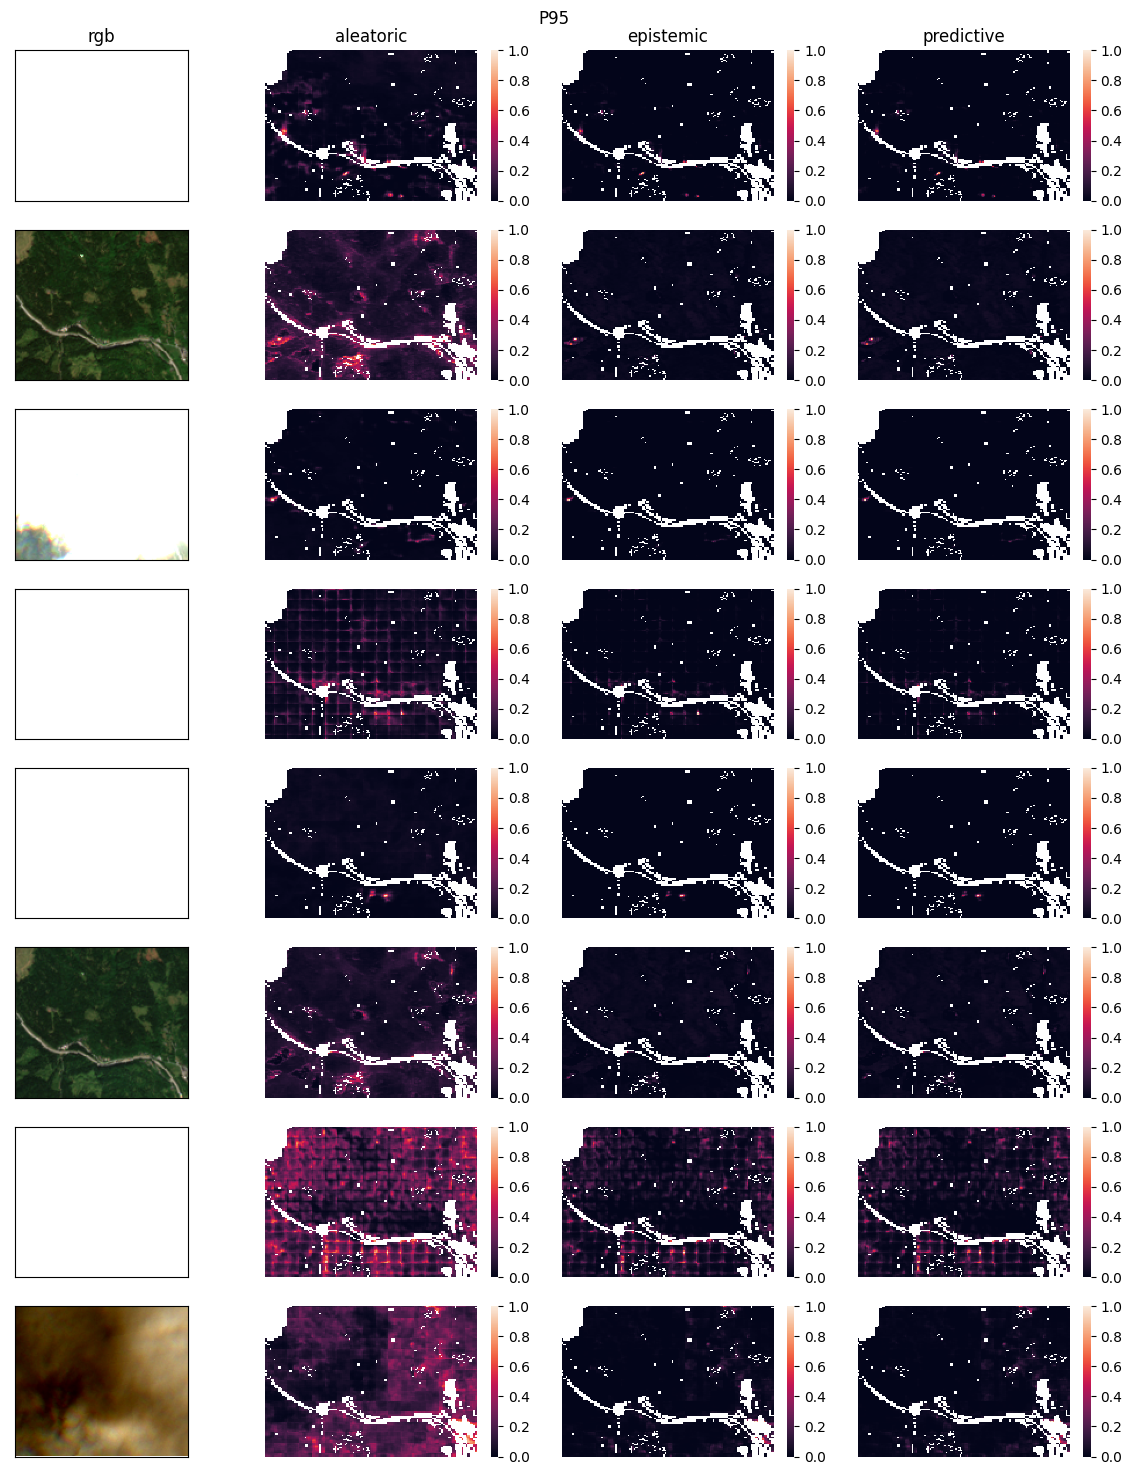

In [22]:
# Uncertainty type sanity check
def clip(arr, bounds):
    bounds = (float(bounds[0]), float(bounds[1]))
    arr = np.where(arr>bounds[1], bounds[1], arr)
    arr = np.where(arr<bounds[0], bounds[0], arr)
    arr -= bounds[0]
    arr /= (bounds[1]-bounds[0])
    return arr

def norm2d(x, mn=None, mx=None, a=0, b=1): 
    if mn is None: mn = np.nanmin(x)
    if mx is None: mx = np.nanmax(x)
    return (b-a)*(x-mn)/(mx-mn)+a

def showUncertaintyType(
    dirs,
    s2repr_dirs,
    titles,
    variable_name, 
    variable_index,
    islice=None,
    jslice=None,
    save_name=None,
    figsize=(12,15)
):
    if titles is not None:
        assert isinstance(titles, list) and len(titles)==len(dirs)
    fig, axs = plt.subplots(ncols=4, nrows=len(dirs), figsize=figsize)
    for i, d in enumerate(dirs):
        dir_name = d.split("/")[-1]
        pid = dir_name.split("_")[0]
        img_path = list(Path(os.path.join(s2repr_dirs, dir_name, pid)).glob("*.tif"))[0]
        aleatoric_path = Path(os.path.join(d, f"{pid}_aleatoric.tif"))
        epistemic_path = Path(os.path.join(d, f"{pid}_epistemic.tif"))
        predictive_path = Path(os.path.join(d, f"{pid}_variance.tif"))
        with rasterio.open(img_path) as f:
            rgb = f.read([4,3,2])
            if islice is not None and jslice is not None:
                rgb = rgb[:,islice, jslice]
            rgb = clip(rgb, (0,2000))
            rgb = rgb.transpose(1,2,0)
        with rasterio.open(aleatoric_path) as f:
            aleatoric = f.read(variable_index)
            if islice is not None and jslice is not None:
                aleatoric = aleatoric[islice, jslice]
        with rasterio.open(epistemic_path) as f:
            epistemic = f.read(variable_index)
            if islice is not None and jslice is not None:
                epistemic = epistemic[islice, jslice]
        with rasterio.open(predictive_path) as f:
            predictive = f.read(variable_index)
            if islice is not None and jslice is not None:
                predictive = predictive[islice, jslice]
        predmin, predmax = np.nanmin(predictive), np.nanmax(predictive)
        aleatoric = norm2d(aleatoric)
        epistemic = norm2d(epistemic)
        predictive = norm2d(predictive)
        axs[i,0].imshow(rgb)
        sns.heatmap(aleatoric, vmin=0, vmax=1, ax=axs[i,1])
        sns.heatmap(epistemic, vmin=0, vmax=1, ax=axs[i,2])
        sns.heatmap(predictive, vmin=0, vmax=1, ax=axs[i,3])
        if i==0:
            axs[i,0].set_title("rgb")
            axs[i,1].set_title("aleatoric")
            axs[i,2].set_title("epistemic")
            axs[i,3].set_title("predictive")
    for ax in axs.flatten():
        ax.set_xticks([])
        ax.set_yticks([])
    if titles is not None:
        for i, title in enumerate(titles):
            axs[i,0].set_ylabel(title)
    fig.suptitle(variable_name)
    plt.tight_layout()
    if save_name is not None: savefig(fig, save_name)
    plt.show()
showUncertaintyType(valid_dirs, S2REPRDIR, None, "P95", 1, islice, jslice)